## Estimated error comparisons for SuperLearner
How do the three error types compare:

+ actual error (i.e. observations - predictions)
+ estimated error (using predicted value as an estimator for the error)
+ uncertainty in predictions (standard deviation across SL ensemble members)

Different ways to display the errors:

+ observed units (mg O2 consumed per L of sediment per hour)
+ log10(observed units)
+ percentage error


In [1]:
! conda install -y -q pandas matplotlib

Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [3]:
# Change branch here - broadly the results as described with
# the Nov-2023-log10-DO-update-correct branch are consisent
# with several other branches that were inspected manually.
branch = 'Nov-2023-log10-DO-update-correct'
#branch = 'Nov-2023-log10'
#branch = 'Oct-2023-log10'
all_merge = pd.read_csv('../fig-model-score-evolution/intermediate_branch_data/'+branch+'/output_obs_avgpre_stdpre_merged.csv')

## Plot errors in log10 space

The respiration rates and their errors span many orders of magnitude so log10 space is probably the best way to view them.

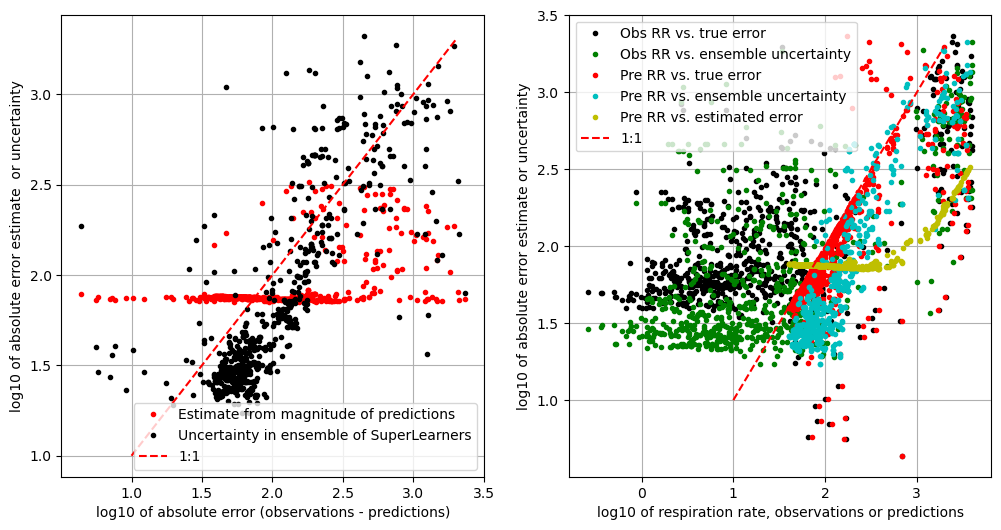

In [4]:
# Plot the observed errors versus the other two metrics
# on a log10(abs()) basis
fig, [ax,ax2] = plt.subplots(1,2,figsize=(12,6))

# True error
true_error = np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'] - all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg']))

# Average estimated error and its uncertainty
avg_est_error = np.log10(np.abs(all_merge['mean.error']))
uncert_est_error = np.log10(np.abs(all_merge['mean.error_pre_std']))

# This was a unique field in the merge operation
# above and so it doesn't get the _pre_std suffix
uncert_in_prediction = np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']))

#ax.errorbar(true_error,avg_est_error,yerr=uncert_est_error,fmt='r.')
ax.plot(true_error,avg_est_error,'r.')
ax.plot(true_error,uncert_in_prediction,'k.')

ax.plot(np.log10([10,2000]),np.log10([10,2000]),'r--')

ax.set_xlabel('log10 of absolute error (observations - predictions)')
ax.set_ylabel('log10 of absolute error estimate  or uncertainty')

ax.legend(['Estimate from magnitude of predictions','Uncertainty in ensemble of SuperLearners','1:1'])
ax.grid()

#==============================
# Second subpanel
#==============================

# Plot the magnitude of the error versus the magnitude of the observation
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'])),
    true_error,'k.')

# Plot the magnitude of the uncertainty versus the magnitude of the observation
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'])),
    uncert_in_prediction,'g.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])),
    true_error,'r.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])),
    uncert_in_prediction,'c.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])),
    avg_est_error,'y.')

# Plot 1:1 line
ax2.plot(np.log10([10,2000]),np.log10([10,2000]),'r--')

ax2.grid()
ax2.set_xlabel('log10 of respiration rate, observations or predictions')
ax2.set_ylabel('log10 of absolute error estimate or uncertainty')
ax2.legend(
    ['Obs RR vs. true error',
     'Obs RR vs. ensemble uncertainty',
     'Pre RR vs. true error',
     'Pre RR vs. ensemble uncertainty',
     'Pre RR vs. estimated error',
     '1:1'])

## Left panel - comparing observed errors to predicted errors
+ Black dots are the observed error versus the uncertainty in the prediction as measured by the ensemble of SuperLearners spread. The ensemble spread is a good estimator of the error over a wide range of scales. This error estimate is biased low relative to the observed error.
+ The estimate built on the magnitude of the predictions has only a weak correspondence with the observed error.

## Right panel - comparing observed respiration rates to predicted errors
+ Black dots are the observed respiration rates versus the true error between observations and ML predictions. Overall, there are many sites where the error is greater than the actual predicted value. This applies, especially, to the cold spots. The relationship between true error and magnitude of ML prediction is weak which supports the scatter in the red dots in the left panel.
+ From the ML observations vs. predictions scatter plots and histograms, we know that the ML models tend to be biased predicting higher respiration rates especially for the cold spots. So, when we plot errors versus the predicted values (red, cyan, and gold dots) - most of the dots are shifted to the right of the plot compared to the dots based on the observed respiration rates (black, green).
+ The close association between the predicted values (ensemble average) and the true error is due to the fact that we are basically plotting `|x-y|` versus `y` where `y` is the predicted value and `x` is the observed value. For small values of `x`, we simply recover `y`. And, since the ML models are biased with `y` often substantially bigger than `x` (especially when predicting the cold spots), we will get values that are close, but a little less than `y`. For any values of `x` in the neighborhood of `y`, we get values that are always less than `y`; the larger `x` is, the further we go from the 1:1 line (i.e. the red dots clinging to the bottom of the 1:1 line). It is only for very very large values of `x` relative to `y` that points can go above the 1:1 line.
+ We compute the error as log10(abs(obs - pre) - this approach causes the red dots clustering pattern **by construction**, discussed immediately above.  What if we adjust for the scale BEFORE we compute the erorr? For example `abs( log10( abs(obs) ) - log10( abs(pre) ) )`. Try this below.
+ As noted above, the uncertainty based on the spread of the ensemble is biased low relative to the observed error. This shifts all the cyan points further below the red dots, although since the uncertainty of the ensemble spread is a good indicator of the observed error, the cyan points track closely with the red dots.
+ Overall, the average estimated error is nearly always less than the predicted values and follows a tight linear relationship (see normal units plot, below) with the predicted values (as expected).

## Conclusions:
1. The ensemble spread is a good estimate of the true/observed error, but it is biased slightly low.
2. Because the true error is related to the magnitude of the predictions (due to the mathematical construction of the true error), the uncertainty in the ensemble spread also tracks the magnitude of the predictions closely.
3. It is not a surpise, then, that the CONUS maps of predictions and error exhibit broadly the same spatial patterns.

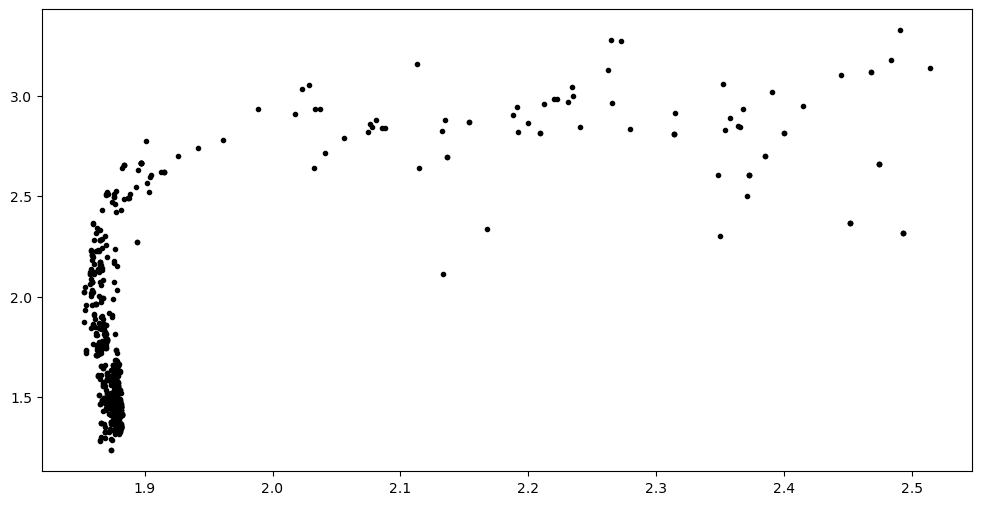

In [5]:
# Verify that predicted (SuperLearner estimated) error correlates with SuperLearner ensemble spread
fig, ax = plt.subplots(figsize=(12,6))

# Log10-Log10 plot
ax.plot(avg_est_error,uncert_in_prediction,'k.')

# Original units plot
#ax.plot(all_merge['mean.error'],all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'],'k.')

In [6]:
# Print out the correlation coefficient
r = np.min(np.min(
    np.corrcoef(all_merge['mean.error'],all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])))
print('R = '+str(r))

r2 = r*r
print('R^2= '+str(r2))

R = 0.6947329382378611
R^2= 0.4826538554726117


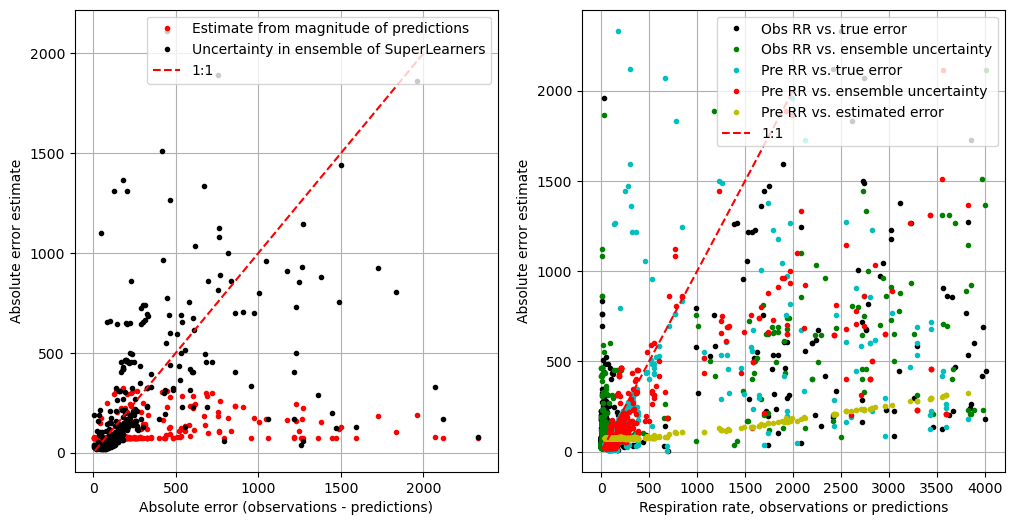

In [7]:
# Plot the observed errors versus the other two metrics
# on a log10(abs()) basis
fig, [ax,ax2] = plt.subplots(1,2,figsize=(12,6))

# True error
true_error = np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'] - all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])

# Average estimated error and its uncertainty
avg_est_error = np.abs(all_merge['mean.error'])
uncert_est_error = np.abs(all_merge['mean.error_pre_std'])

# This was a unique field in the merge operation
# above and so it doesn't get the _pre_std suffix
uncert_in_prediction = np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])

#ax.errorbar(true_error,avg_est_error,yerr=uncert_est_error,fmt='r.')
ax.plot(true_error,avg_est_error,'r.')
ax.plot(true_error,uncert_in_prediction,'k.')

ax.plot([10,2000],[10,2000],'r--')

ax.set_xlabel('Absolute error (observations - predictions)')
ax.set_ylabel('Absolute error estimate')

ax.legend(['Estimate from magnitude of predictions','Uncertainty in ensemble of SuperLearners','1:1'])
ax.grid()

#==============================
# Second subpanel
#==============================

# Plot the magnitude of the error versus the magnitude of the observation
ax2.plot(
    np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs']),
    true_error,'k.')

# Plot the magnitude of the uncertainty versus the magnitude of the observation
ax2.plot(
    np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs']),
    uncert_in_prediction,'g.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg']),
    true_error,'c.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg']),
    uncert_in_prediction,'r.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg']),
    avg_est_error,'y.')

# Plot 1:1 line
ax2.plot([10,2000],[10,2000],'r--')

ax2.grid()
ax2.set_xlabel('Respiration rate, observations or predictions')
ax2.set_ylabel('Absolute error estimate')
ax2.legend(
    ['Obs RR vs. true error',
     'Obs RR vs. ensemble uncertainty',
     'Pre RR vs. true error',
     'Pre RR vs. ensemble uncertainty',
     'Pre RR vs. estimated error',
     '1:1'])

In [8]:
# Print some correlation coefficients from left panel
#ax.plot(true_error,avg_est_error,'r.')
#ax.plot(true_error,uncert_in_prediction,'k.')

r = np.min(np.min(np.corrcoef(true_error,avg_est_error)))
print('True error vs. avg. est. error: R = '+str(r)+' R^2= '+str(r*r))

r = np.min(np.min(np.corrcoef(true_error,uncert_in_prediction)))
print('True error vs. Uncert. in prediction: R = '+str(r)+' R^2= '+str(r*r))


True error vs. avg. est. error: R = 0.3821611732263851 R^2= 0.14604716232176712
True error vs. Uncert. in prediction: R = 0.5853637825774102 R^2= 0.34265075795333355


These plots are the same as above but they are in normal space instead of log10-log10 space. Key points:
+ **Left panel:** the estimated error from the SuperLearner workflow is biased very low compared to the observed error. Removing all log10 scaling helps show that there is indeed a relationship between the ensemble spread and the true error, but this relationship degrades for larger and larger predictions.
+ **Right panel:** the near linear relationship between predicted respiration rate and the SuperLearner workflow error estimate is clear here with the gold dots. There is also a relationship between the size of the prediction and the uncertainty.

## Adjust for the scale before computing the error

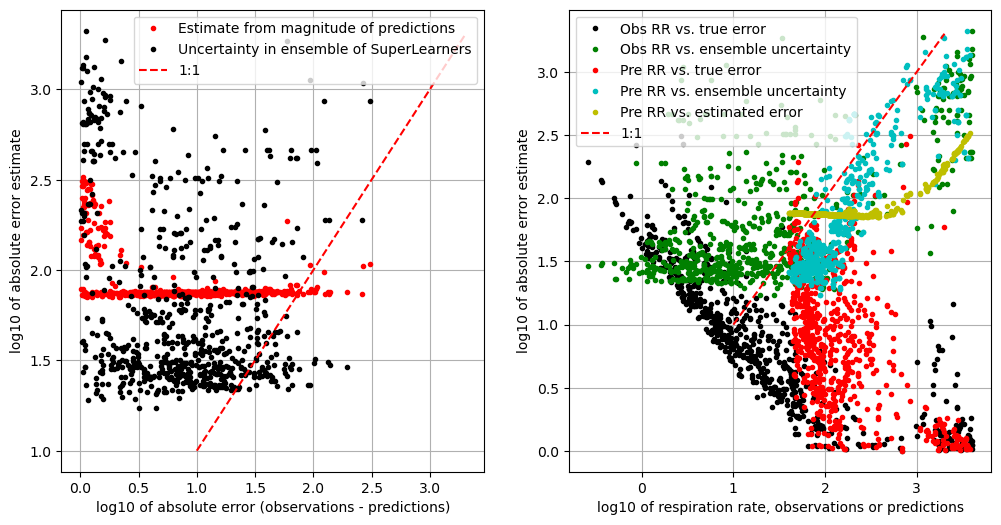

In [9]:
# Plot the observed errors versus the other two metrics
# on a log10(abs()) basis
fig, [ax,ax2] = plt.subplots(1,2,figsize=(12,6))

# True error
true_error = np.abs(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'])) - np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])))

# Average estimated error and its uncertainty
avg_est_error = np.log10(np.abs(all_merge['mean.error']))
uncert_est_error = np.log10(np.abs(all_merge['mean.error_pre_std']))

# This was a unique field in the merge operation
# above and so it doesn't get the _pre_std suffix
uncert_in_prediction = np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']))

#ax.errorbar(true_error,avg_est_error,yerr=uncert_est_error,fmt='r.')
ax.plot(true_error,avg_est_error,'r.')
ax.plot(true_error,uncert_in_prediction,'k.')

ax.plot(np.log10([10,2000]),np.log10([10,2000]),'r--')

ax.set_xlabel('log10 of absolute error (observations - predictions)')
ax.set_ylabel('log10 of absolute error estimate')

ax.legend(['Estimate from magnitude of predictions','Uncertainty in ensemble of SuperLearners','1:1'])
ax.grid()

#==============================
# Second subpanel
#==============================

# Plot the magnitude of the error versus the magnitude of the observation
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'])),
    true_error,'k.')

# Plot the magnitude of the uncertainty versus the magnitude of the observation
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'])),
    uncert_in_prediction,'g.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])),
    true_error,'r.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])),
    uncert_in_prediction,'c.')

# Plot the magnitude of the uncertainty versus the magnitude of the prediction
ax2.plot(
    np.log10(np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])),
    avg_est_error,'y.')

# Plot 1:1 line
ax2.plot(np.log10([10,2000]),np.log10([10,2000]),'r--')

ax2.grid()
ax2.set_xlabel('log10 of respiration rate, observations or predictions')
ax2.set_ylabel('log10 of absolute error estimate')
ax2.legend(
    ['Obs RR vs. true error',
     'Obs RR vs. ensemble uncertainty',
     'Pre RR vs. true error',
     'Pre RR vs. ensemble uncertainty',
     'Pre RR vs. estimated error',
     '1:1'])

**Left:** I think this is not a good approach because we are applying a non-linear transformation (the log10) to the values *before* we compare them. This approach shrinks differences to the point that they become all more or less the same -> horizontal blobs where it doesn't matter what your error is anymore and the only structure is in the banding which is provided by the values with log transforms applied after the error calculation.

## Percentage error

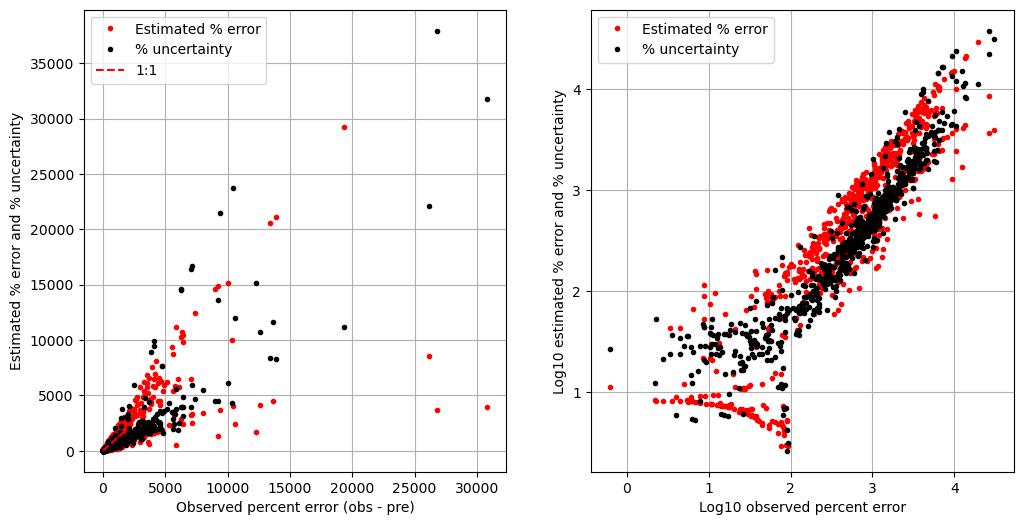

In [15]:
# Plot the observed errors versus the other two metrics
# on a log10(abs()) basis
fig, [ax,ax2] = plt.subplots(1,2,figsize=(12,6))

# True error
true_error = np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'] - all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])

# Percent error
true_percent_error = 100.0*np.abs(
    (all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'] - all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_pre_avg'])/all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs']
)

# Avg estimated percentage error
avg_est_percent_error = 100.0*(np.abs(all_merge['mean.error']/all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs']))

# This was a unique field in the merge operation
# above and so it doesn't get the _pre_std suffix
percent_uncert_in_prediction = 100.0*np.abs(all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']/all_merge['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_obs'])

ax.plot(true_percent_error,avg_est_percent_error,'r.')
ax.plot(true_percent_error,percent_uncert_in_prediction,'k.')

ax.plot([10,2000],[10,2000],'r--')

ax.set_xlabel('Observed percent error (obs - pre)')
ax.set_ylabel('Estimated % error and % uncertainty')

ax.legend(['Estimated % error','% uncertainty','1:1'])
ax.grid()

#=========================================

ax2.plot(np.log10(true_percent_error),np.log10(avg_est_percent_error),'r.')
ax2.plot(np.log10(true_percent_error),np.log10(percent_uncert_in_prediction),'k.')

#ax.plot([10,2000],[10,2000],'r--')

ax2.set_xlabel('Log10 observed percent error')
ax2.set_ylabel('Log10 estimated % error and % uncertainty')

ax2.legend(['Estimated % error','% uncertainty','1:1'])
ax2.grid()

